<h1 align="center">☁️ - Cloudy regions segmentation 👨‍💻🔬</h1>

<h2 align="center">Testing image preprocessing</h2>
<p style="text-align:center">
   Thomas Bury, Afonso Alves, Daniel Staudegger<br>
   Allianz<br>
</p>

Testing preprocessing. Not sure that will be usefull because hidden layers are supposed to extract edges and shapes.

We'll need to:

 * Collapse channels into gray-scale (no need of colours)
 * centering (subtracting the per-channel/gray-scale mean pixel values calculated on the training dataset)
 * Training data augmentation, E.G. random rescaling, horizontal flips, perturbations to brightness, contrast, and color, random cropping.
 * Test-time augmentation should probably involve both a mixture of multiple rescaling of each image as well as predictions for multiple different systematic crops of each rescaled version of the image.

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import yaml
import swifter
import seaborn as sns
import scicomap as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import patches as patches
from pprint import pprint

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import set_my_plt_style, plot_cloud, plot_rnd_cloud, draw_label_only
from pyreidolia.mask import bounding_box, rle_to_mask, get_binary_mask_sum
from pyreidolia.img import get_resolution_sharpness

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport pyreidolia

# Setting global matplotlib style
If you don't like, just revert back to defaults using `plt.style.use('default')`

In [19]:
# A nicer style for mpl
set_my_plt_style(height=6, width=8, linewidth=1.5)

# A better colormap


sc_map = sc.ScicoSequential(cmap='tropical')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("tropical", sc_cmap)

sc_map = sc.ScicoSequential(cmap='neutral')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("neutral", sc_cmap)

sc_map = sc.ScicoSequential(cmap='neutral_r')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("neutral_r", sc_cmap)

C:\Users\e400086\AppData\Local\Temp/ipykernel_4180/4002651542.py:13: UserWarning: Trying to register the cmap 'tropical' which already exists.
  mpl.cm.register_cmap("tropical", sc_cmap)
C:\Users\e400086\AppData\Local\Temp/ipykernel_4180/4002651542.py:21: UserWarning: Trying to register the cmap 'neutral' which already exists.
  mpl.cm.register_cmap("neutral", sc_cmap)
C:\Users\e400086\AppData\Local\Temp/ipykernel_4180/4002651542.py:29: UserWarning: Trying to register the cmap 'neutral_r' which already exists.
  mpl.cm.register_cmap("neutral_r", sc_cmap)


# Load the config file for the paths
To avoid to hardcode the paths in a versioned file, let's create a `paths.yml` which will **not** be versioned. So that the paths are not overwritten when we pull or merge from the GitHub repo. The `paths.yml` should have a structure like:

```yml
# data
data:
  test: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/test_images/"
  train: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/train_images/"
  docs: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/"

# Path to store all notebooks, ideally not versioned
notebooks: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/notebooks/"

# Path to store all outputs (correlations, jsons, excel, etc)
output: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/output/"

# Path to store all python scripts, for versioning
scripts: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/scripts/"

# Path to studies
studies: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/studies/"

# Path to reports
reports: "C:/Users/xtbury/Documents/Projects/Pyreidolia/reports/"
```

In [5]:
def string_print(df):
    return print(df.to_string().replace('\n', '\n\t'))

In [6]:
# Where is my yaml ? "C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml"

paths_yml = input("where is the paths.yml config file?")
with open(paths_yml, "r") as ymlfile:
    path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

pprint(path_dic)

where is the paths.yml config file?C:\Users\e400086\Desktop\Docs\DS_Certificate_Sorbonne_and_CV\02_Project_Cloud_Regions\paths.yml
{'data': {'docs': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/00_Docs_and_Links/',
          'test': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/01_Data/test_images/',
          'train': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/01_Data/train_images/'},
 'notebooks': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/03_Notebooks/',
 'output': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/02_Outputs/',
 'reports': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/',
 'scripts': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/04_Scripts/',
 'studies': 'C:/Users/e400086

In [7]:
train_csv_path = path_dic['data']['docs'] + 'train.csv'
train_pq_path = path_dic['data']['docs'] + "train_info_clean.parquet"
train_data = path_dic['data']['train'] 
test_data = path_dic['data']['test'] 
report_path = path_dic['reports']

In [8]:
train_doc = pd.read_parquet(train_pq_path)
train_doc.head()

,image_label,encoded_pixels,image_id,label,label_encodedpix,is_mask,mask_pixel_sum,resolution,sharpness,quality
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,"[Fish, 264918 937 266318 937 267718 937 269118...",True,932312.0,"[1400, 2100, 3]",26.944502,good
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,"[Flower, 1355565 1002 1356965 1002 1358365 100...",True,1156107.0,"[1400, 2100, 3]",26.944502,good
2,0011165.jpg_Gravel,None,0011165.jpg,Gravel,"[Gravel, None]",False,NaN,"[1400, 2100, 3]",26.944502,good
3,0011165.jpg_Sugar,None,0011165.jpg,Sugar,"[Sugar, None]",False,NaN,"[1400, 2100, 3]",26.944502,good
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,"[Fish, 233813 878 235213 878 236613 878 238010...",True,1684325.0,"[1400, 2100, 3]",22.857262,good


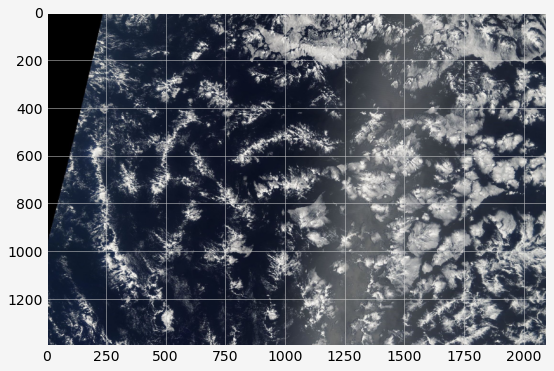

In [9]:
image_name = train_doc.image_id[0]
image_start = plt.imread(os.path.join(train_data, image_name))

fig, ax = plt.subplots()
ax.imshow(image_start) 
plt.show()

# Read in gray scale

The colors are then purely articificial, for better visualization (uniform cmap)

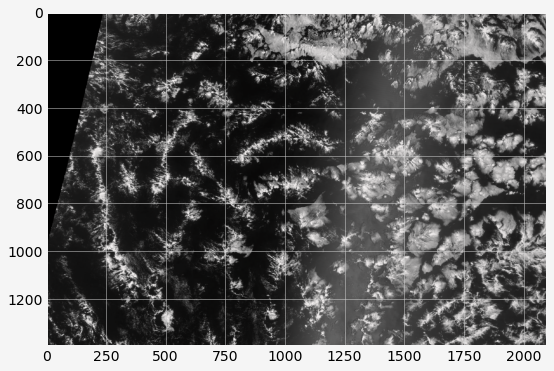

In [10]:
img_gray = cv2.imread(os.path.join(train_data, image_name), cv2.IMREAD_GRAYSCALE) 
fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='neutral') 
plt.show()

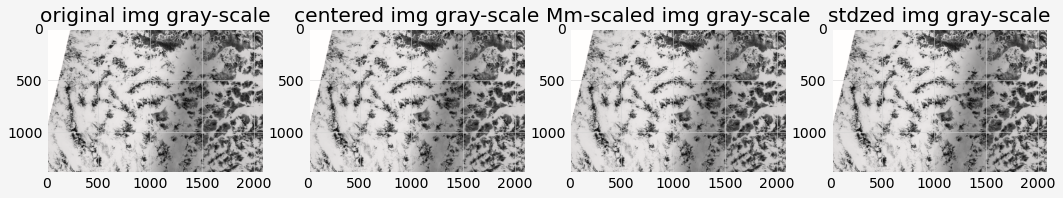

In [11]:
fig = plt.figure(figsize=(16, 4))
fig.add_subplot(1, 4, 1)
plt.imshow(img_gray, cmap='neutral_r') 
plt.title("original img gray-scale")
          
fig.add_subplot(1, 4, 2)
plt.imshow(img_gray - np.mean(img_gray[:]), cmap='neutral_r') 
plt.title("centered img gray-scale") 

fig.add_subplot(1, 4, 3)
scaled_img = cv2.normalize(img_gray, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(scaled_img, cmap='neutral_r') 
plt.title("Mm-scaled img gray-scale")

fig.add_subplot(1, 4, 4)
std_img = (img_gray - np.mean(img_gray[:]))/np.std(img_gray[:])
plt.imshow(std_img, cmap='neutral_r') 
plt.title("stdzed img gray-scale")
          
plt.show()

# Extract shapes

 * Resize
 * Threshold the image (maximizing the contrast between sea and clouds)
 * Gaussian filter (remove noise)
 * Erosion
 * Dilate erosion
 * Substract the latter from the original image
 
Let's start by eroding the resized image with different kernels. 

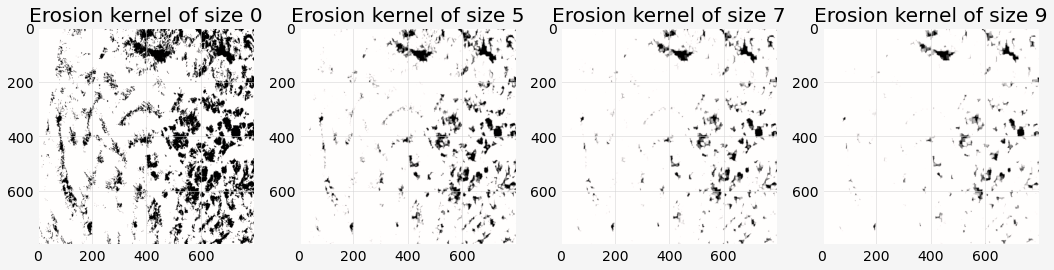

In [12]:
img_gray = cv2.resize(img_gray, (800, 800))
_, img_gray = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)

# same kernel size than for the erosion
gb_filter = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=0, sigmaY=0)

erosion_list = []

kernel_size_list = [5, 7, 9]

for kernel_size in kernel_size_list:
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    erosion_list.append(cv2.erode(gb_filter, kernel))

erosion_list.insert(0, img_gray)  
list_length = len(erosion_list)


fig = plt.figure(figsize=(4*list_length, 4*list_length))
kernel_size_list.insert(0, 0)
for i, im in enumerate(erosion_list):
    fig.add_subplot(1, list_length, i+1)
    plt.imshow(im, cmap='neutral_r')
    plt.title(f"Erosion kernel of size {kernel_size_list[i]}")


plt.show();

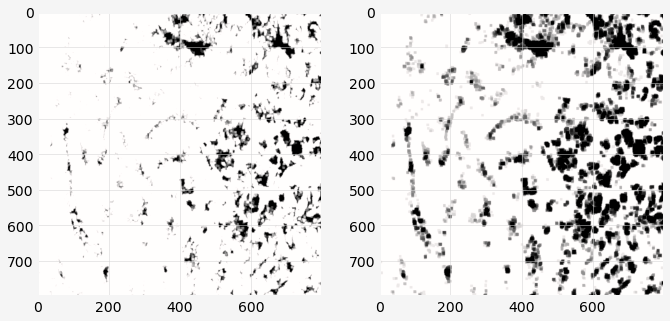

In [13]:
kernel = np.ones((7, 7), np.uint8)
dilation = cv2.dilate(erosion_list[1], kernel)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(erosion_list[1], cmap='neutral_r')
fig.add_subplot(1, 2, 2)
plt.imshow(dilation, cmap='neutral_r')
plt.show();

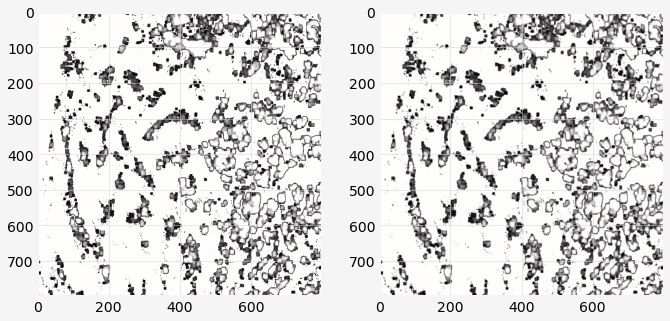

In [14]:
diff = img_gray - dilation

# Filtering the extracted shapes
filter_gb = cv2.GaussianBlur(diff, ksize=(3, 3), sigmaX=0, sigmaY=0)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(diff, cmap='neutral_r')
fig.add_subplot(1, 2, 2)
plt.imshow(filter_gb, cmap='neutral_r')
plt.show();

## Finding contours

### Using thresholding

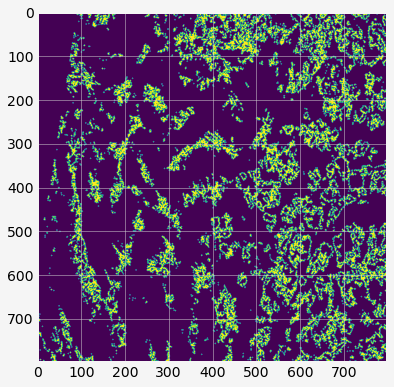

In [15]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours = cv2.findContours(img_gray, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
# draw contours on the original image
canvas = np.zeros_like(img_gray)

for contour in contours:
    cv2.drawContours(canvas, contour, -1, (255, 187, 0), 2)
plt.figure()
plt.imshow(canvas)
plt.show();

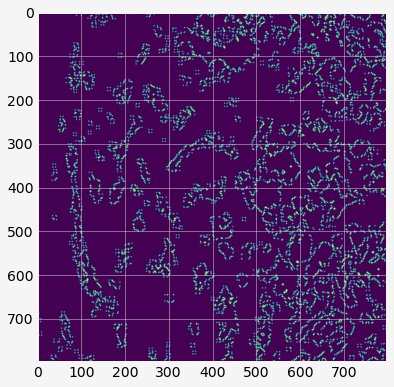

In [16]:

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours = cv2.findContours(dilation, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
# draw contours on the original image
canvas = np.zeros_like(img_gray)

for contour in contours:
    cv2.drawContours(canvas, contour, -1, (255, 187, 0), 2)
plt.figure()
plt.imshow(canvas)
plt.show();

### Using Canny edge detector on the dilated img

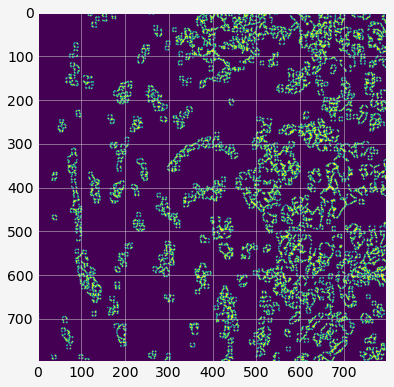

In [17]:
edges = cv2.Canny(dilation, 100, 200)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours = cv2.findContours(edges, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
# draw contours on the original image
canvas = np.zeros_like(img_gray)

for contour in contours:
    cv2.drawContours(canvas, contour, -1, (255, 187, 0), 2)
plt.figure()
plt.imshow(canvas)
plt.show();

# Extracting background

trying to remove unnecessary information, unlikely to work since basically removing the background will leave us with a unique array (the image is already polarized black/white or sea/cloud)

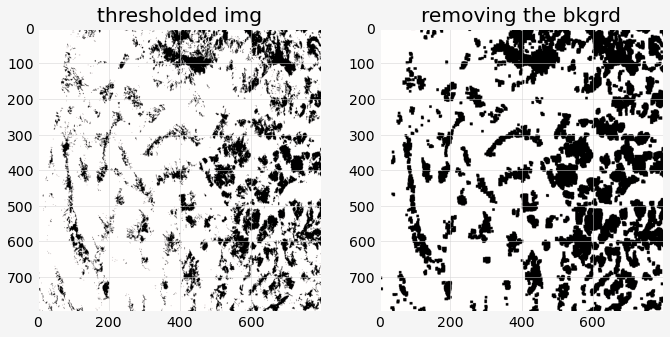

In [18]:
backSub = cv2.createBackgroundSubtractorMOG2() #cv2.createBackgroundSubtractorKNN()
img = dilation.copy()
fg_mask = backSub.apply(img)


fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(erosion_list[0], cmap='neutral_r')
plt.title('thresholded img')
fig.add_subplot(1, 2, 2)
plt.imshow(fg_mask, cmap='neutral')
plt.title('removing the bkgrd')
plt.show();

This step might help to highlight the cloud structure, prior feeding the deep NN.